In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
import pickle


In [2]:
sp_labels_alc1 = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "1.0 gcc, 2000K",
    4: "2.0 gcc, 6000K",
    5: "3.6 gcc, 6000K",
    6: "3.0 gcc, 8000K",
    7: "Diamond, 300K",
    8: "Graphite, 300K",
    9: "Graphite, 1500K",
    10: "2.0 gcc, 7000K",
    11: "2.5 gcc, 6000K"
    }

sp_labels_alc2 = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "0.5 gcc, 1000K, Bad",
    4: "1.0 gcc, 2000K",
    5: "2.0 gcc, 6000K",
    6: "2.0 gcc, 6000K, Bad",
    7: "3.6 gcc, 6000K",
    8: "3.6 gcc, 6000K, Bad",
    9: "3.0 gcc, 8000K",
    10: "3.0 gcc, 8000K, Bad"
    }

sp_labels_alc3 = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "1.0 gcc, 2000K",
    4: "2.0 gcc, 6000K",
    5: "3.6 gcc, 6000K",
    6: "3.0 gcc, 8000K",
    7: "3.0 gcc, 8000K, Bad"
    }

sp_labels_alc4 = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "1.0 gcc, 2000K",
    4: "2.0 gcc, 6000K",
    5: "3.6 gcc, 6000K",
    6: "3.0 gcc, 8000K"
    }

sp_labels_alc5 = sp_labels_alc4

sp_labels_alc1_pbe = {
    0: "Diamond, 3000K",
    1: "Graphite, 3000K",
    2: "0.5 gcc, 1000K",
    3: "1.0 gcc, 2000K",
    4: "2.0 gcc, 6000K",
    5: "2.0 gcc, 6000K, Bad",
    6: "3.0 gcc, 8000K",
    7: "3.0 gcc, 8000K, Bad",
    6: "3.0 gcc, 8000K",
    7: "3.0 gcc, 8000K, Bad"
    }




In [3]:
with open("2b_alc_avg_pd_equilibrium.ary", 'rb') as pickle_file:
    avg_pd_2b = pickle.load(pickle_file)

with open("3b_alc_avg_pd_equilibrium.ary", 'rb') as pickle_file:
    avg_pd_3b = pickle.load(pickle_file)

with open("4b_alc_avg_pd_equilibrium.ary", 'rb') as pickle_file:
    avg_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
combined_array = np.concatenate((avg_pd_2b, avg_pd_3b, avg_pd_4b), axis=1)

# Verify the shape of the combined array
print(combined_array.shape)  # Output will be (12, 180, 1)

# Reshape the array to (12, 60) before creating the DataFrame
reshaped_data = np.array(combined_array).reshape(58,180)

print(reshaped_data.shape)

# Create a DataFrame
avg_df = pd.DataFrame(reshaped_data) # Ground Truth

avg_labels = list(range(58))

with open("2b_alc_pd.ary", 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open("3b_alc_pd.ary", 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open("4b_alc_pd.ary", 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

with open("alc_labels", 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

# Initialize master_array
master_array = None

for index, value in enumerate(pd_2b):
    array_2b = value
    array_3b = pd_3b[index]
    array_4b = pd_4b[index]
    all_array = np.concatenate((array_2b, array_3b, array_4b), axis=1)
    #print(np.shape(all_array))
    # Vertically stack all_array to master_array
    if master_array is None:
        master_array = all_array
    else:
        master_array = np.vstack((master_array, all_array))

# Print shape of the master_array
print("Shape of the master array:", master_array.shape)

all_df = pd.DataFrame(master_array)

# Define prediction ranges for ALC predictions

# Define Orders for CM
alc1_order = [7, 0, 8, 9, 1, 2, 3, 4, 10, 11, 5, 6]
alc2_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
alc3_order = [0, 1, 2, 3, 4, 5, 6, 7]
alc4_order = [0, 1, 2, 3, 4, 5, 6]
alc5_order = [0, 1, 2, 3, 4, 5, 6]
alc1_pbe_order = [0, 1, 2, 3, 4, 5, 6, 7]

# (start frame, end frame, start sp, end sp)
prediction_ranges = [
    (0, 300, 0, 13, alc1_order, sp_labels_alc1),   # ALC-1
    (310, 471, 14, 24, alc2_order, sp_labels_alc2), # ALC-2
    (472, 631, 25, 32, alc3_order, sp_labels_alc3), # ALC-3
    (632, 771, 33, 39, alc4_order, sp_labels_alc4), # ALC-4
    (772, 915, 40, 47, alc5_order, sp_labels_alc5), # ALC-5
    (916, 1115, 48, 57, alc1_pbe_order, sp_labels_alc1_pbe) # ALC-1 (PBE)
]

alc_cnt = 1
alc_acc = []
alc_master_list = []
master_labels = []

for start_frame, end_frame, start_sp, end_sp, order, sp_labels in prediction_ranges:
    closest_clusters = []
    alc_df = all_df[start_frame:end_frame+1]
    alc_master_list.append(alc_df)



(58, 180, 1)
(58, 180)
Shape of the master array: (1116, 180)


/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/261102220.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/261102220.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='v

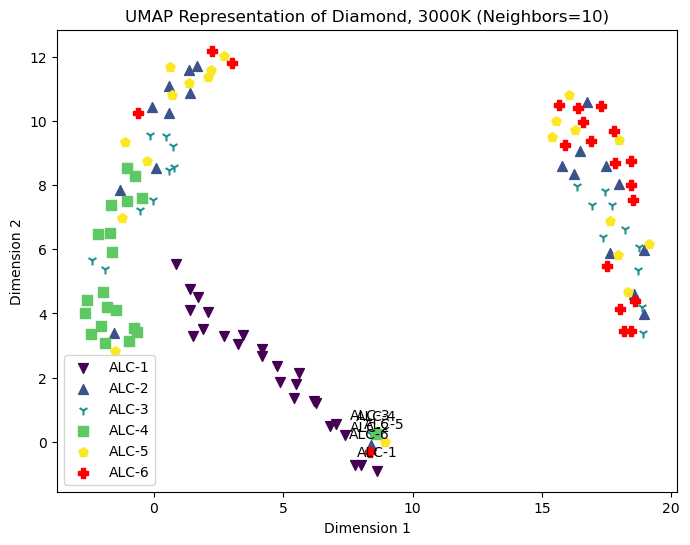

In [4]:
# Function to plot UMAP representation
def plot_umap(embedding, cleaned_labels, title, dft_only):
    plt.figure(figsize=(8, 6))
    label_dict = {}  # Dictionary to store whether each label has been plotted

    shape_map = [".","v","^","1","s","p","P","*","x","d","+","H"]    

    for i in range(len(embedding)):
        x, y = embedding[i]  # Coordinates of the point
        label = int(cleaned_labels.iloc[i])

        # Normalize label data to range [0, 1]
        normalized_label = (label - 1) / (5 - 1)

        # Determine color
        if dft_only == True and label != 1:
            continue
        if label == 6:
            color = "red"
        else:
            if dft_only:
                normalized_label = (i-1)/(26-1)
            color = plt.cm.viridis(normalized_label)

        # Plot points with unique labels and add them to the legend
        if label not in label_dict:
            label_dict[label] = True
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50, label=f"ALC-{label}")
            plt.annotate(f"ALC-{label}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        else:
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50)

    # Add colorbar to show the mapping from index to color
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title(title)
    plt.show()


# Function to process and plot data
def process_and_plot_data(data, labels, title, n_neighbors, dft_only=False):
    # Concatenate data and labels
    stacked_df = pd.concat(data, ignore_index=True)
    stacked_labels = pd.concat(labels, ignore_index=True)
    stacked_df["Labels"] = stacked_labels

    # Drop NaN values and extract cleaned labels
    removedna_df = stacked_df.dropna()
    cleaned_labels = removedna_df["Labels"]

    # Extract removed labels
    removed_labels = removedna_df.drop(columns=["Labels"])

    # Compute UMAP embedding
    umap_model = umap.UMAP(random_state=1, n_components=2, n_neighbors=n_neighbors, min_dist=0.7)
    embedding = umap_model.fit_transform(removed_labels)

    # Plot the embedded data with colors and shapes based on labels
    plot_umap(embedding, cleaned_labels, f'{title} (Neighbors={n_neighbors})', dft_only)

# Read the CSV file into a DataFrame
df = pd.read_csv('../excel_files/Carbon_data_defs.csv', header=1)
df = df[:58]
sp_cnt = 0

# Filter rows where the 'phase' column is equal to 'diamond'
diamond_rows = df[(df['phase'] == 'diamond') & (df['T'] == 3000)]

# # Define your datasets and labels
# diamonds_data = [
#     alc_master_list[i][:int(diamond_rows.iloc[i]["Total frames"])] for i in range(6)
# ]
# Define your datasets and labels
diamonds_data = [
    alc_master_list[i][sp_cnt*int(diamond_rows.iloc[i]["Total frames"]):sp_cnt*int(diamond_rows.iloc[i]["Total frames"])+int(diamond_rows.iloc[i]["Total frames"])] for i in range(6)
]

diamonds_labels = [
    pd.DataFrame(np.full(int(row["Total frames"]), int(row["Eff ALC"]))) for _, row in diamond_rows.iterrows()
]

process_and_plot_data(diamonds_data, diamonds_labels, 'UMAP Representation of Diamond, 3000K', 10, dft_only=False)


/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/992060930.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/992060930.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap='v

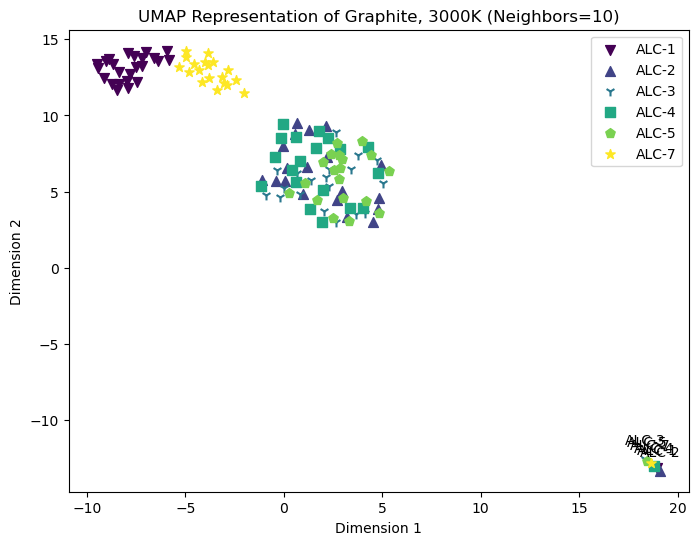

In [5]:
# Function to plot UMAP representation
def plot_umap(embedding, cleaned_labels, title, dft_only):
    plt.figure(figsize=(8, 6))
    label_dict = {}  # Dictionary to store whether each label has been plotted

    shape_map = [".","v","^","1","s","p","P","*","x","d","+","H"]    

    for i in range(len(embedding)):
        x, y = embedding[i]  # Coordinates of the point
        label = int(cleaned_labels.iloc[i])

        # Normalize label data to range [0, 1]
        normalized_label = (label - 1) / (6 - 1)

        # Determine color
        if dft_only == True and label != 1:
            continue
        if label == 6:
            color = "red"
        else:
            if dft_only:
                normalized_label = (i-1)/(26-1)
            color = plt.cm.viridis(normalized_label)

        # Plot points with unique labels and add them to the legend
        if label not in label_dict:
            label_dict[label] = True
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50, label=f"ALC-{label}")
            plt.annotate(f"ALC-{label}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        else:
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50)

    # Add colorbar to show the mapping from index to color
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title(title)
    plt.show()


# Function to process and plot data
def process_and_plot_data(data, labels, title, n_neighbors, dft_only=False):
    # Concatenate data and labels
    stacked_df = pd.concat(data, ignore_index=True)
    stacked_labels = pd.concat(labels, ignore_index=True)
    stacked_df["Labels"] = stacked_labels

    # Drop NaN values and extract cleaned labels
    removedna_df = stacked_df.dropna()
    cleaned_labels = removedna_df["Labels"]

    # Extract removed labels
    removed_labels = removedna_df.drop(columns=["Labels"])

    # Compute UMAP embedding
    umap_model = umap.UMAP(random_state=1, n_components=2, n_neighbors=n_neighbors, min_dist=0.7)
    embedding = umap_model.fit_transform(removed_labels)

    # Plot the embedded data with colors and shapes based on labels
    plot_umap(embedding, cleaned_labels, f'{title} (Neighbors={n_neighbors})', dft_only)

# Read the CSV file into a DataFrame
df = pd.read_csv('../excel_files/Carbon_data_defs.csv', header=1)
df = df[:58]
sp_cnt = 1

# Filter rows where the 'phase' column is equal to 'diamond'
graphite_rows = df[(df['phase'] == 'graphite') & (df['T'] == 3000)]

# Define your datasets and labels
graphite_data = [
    alc_master_list[i][sp_cnt*int(graphite_rows.iloc[i]["Total frames"]):sp_cnt*int(graphite_rows.iloc[i]["Total frames"])+int(graphite_rows.iloc[i]["Total frames"])] for i in range(6)
]

graphite_labels = [
    pd.DataFrame(np.full(int(row["Total frames"]), int(row["Eff ALC"]))) for _, row in graphite_rows.iterrows()
]

process_and_plot_data(graphite_data, graphite_labels, 'UMAP Representation of Graphite, 3000K', 10, dft_only=False)


/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/2264441510.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/2264441510.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap=

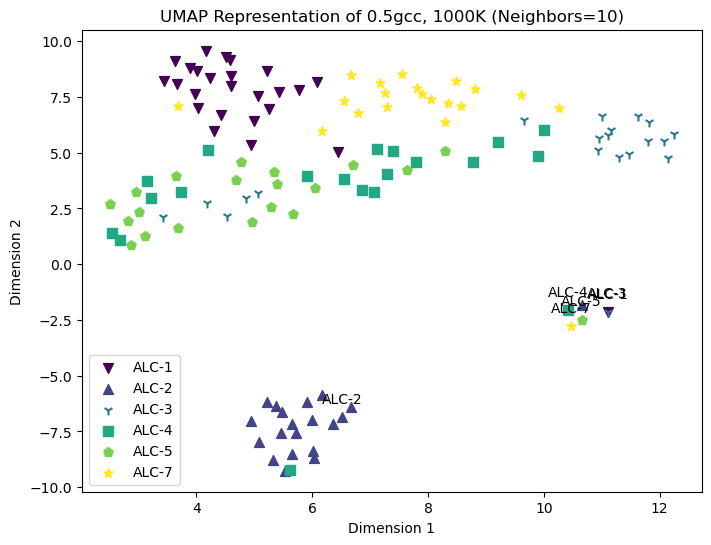

In [6]:
# Function to plot UMAP representation
def plot_umap(embedding, cleaned_labels, title, dft_only):
    plt.figure(figsize=(8, 6))
    label_dict = {}  # Dictionary to store whether each label has been plotted

    shape_map = [".","v","^","1","s","p","P","*","x","d","+","H"]    

    for i in range(len(embedding)):
        x, y = embedding[i]  # Coordinates of the point
        label = int(cleaned_labels.iloc[i])

        # Normalize label data to range [0, 1]
        normalized_label = (label - 1) / (6 - 1)

        # Determine color
        if dft_only == True and label != 1:
            continue
        if label == 6:
            color = "red"
        else:
            if dft_only:
                normalized_label = (i-1)/(26-1)
            color = plt.cm.viridis(normalized_label)

        # Plot points with unique labels and add them to the legend
        if label not in label_dict:
            label_dict[label] = True
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50, label=f"ALC-{label}")
            plt.annotate(f"ALC-{label}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        else:
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50)

    # Add colorbar to show the mapping from index to color
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title(title)
    plt.show()


# Function to process and plot data
def process_and_plot_data(data, labels, title, n_neighbors, dft_only=False):
    # Concatenate data and labels
    stacked_df = pd.concat(data, ignore_index=True)
    stacked_labels = pd.concat(labels, ignore_index=True)
    stacked_df["Labels"] = stacked_labels

    # Drop NaN values and extract cleaned labels
    removedna_df = stacked_df.dropna()
    cleaned_labels = removedna_df["Labels"]

    # Extract removed labels
    removed_labels = removedna_df.drop(columns=["Labels"])

    # Compute UMAP embedding
    umap_model = umap.UMAP(random_state=1, n_components=2, n_neighbors=n_neighbors, min_dist=0.7)
    embedding = umap_model.fit_transform(removed_labels)

    # Plot the embedded data with colors and shapes based on labels
    plot_umap(embedding, cleaned_labels, f'{title} (Neighbors={n_neighbors})', dft_only)

# Read the CSV file into a DataFrame
df = pd.read_csv('../excel_files/Carbon_data_defs.csv', header=1)
df = df[:58]
sp_cnt = 3

# Filter rows where the 'phase' column is equal to 'diamond'
low_05gcc_rows = df[(df['phase'] == 'graphite') & (df['T'] == 3000)]

# Define your datasets and labels
low_05gcc_data = [
    alc_master_list[i][sp_cnt*int(low_05gcc_rows.iloc[i]["Total frames"]):sp_cnt*int(low_05gcc_rows.iloc[i]["Total frames"])+int(low_05gcc_rows.iloc[i]["Total frames"])] for i in range(6)
]

low_05gcc_labels = [
    pd.DataFrame(np.full(int(row["Total frames"]), int(row["Eff ALC"]))) for _, row in low_05gcc_rows.iterrows()
]

process_and_plot_data(low_05gcc_data, low_05gcc_labels, 'UMAP Representation of 0.5gcc, 1000K', 10, dft_only=False)


/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/2053478913.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50, label=f"ALC-{label}")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/2053478913.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, cmap=

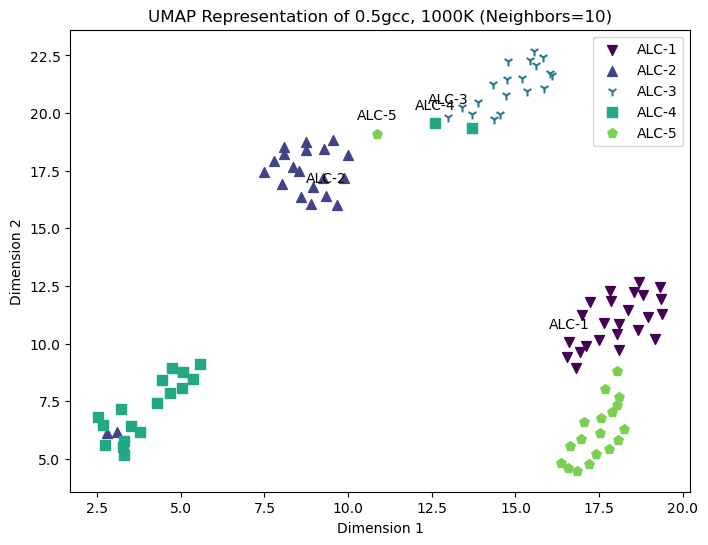

In [7]:
# Function to plot UMAP representation
def plot_umap(embedding, cleaned_labels, title, dft_only):
    plt.figure(figsize=(8, 6))
    label_dict = {}  # Dictionary to store whether each label has been plotted

    shape_map = [".","v","^","1","s","p","P","*","x","d","+","H"]    
    # length = len(cleaned_labels[-1])
    # filled_list = [6] * length
    # cleaned_labels[-1] = filled_list

    for i in range(len(embedding)):
        x, y = embedding[i]  # Coordinates of the point
        label = int(cleaned_labels.iloc[i])
        # Normalize label data to range [0, 1]
        normalized_label = (label - 1) / (6 - 1)

        # Determine color
        if dft_only == True and label != 1:
            continue
        if label == 6:
            color = "red"
        else:
            if dft_only:
                normalized_label = (i-1)/(26-1)
            color = plt.cm.viridis(normalized_label)

        # Plot points with unique labels and add them to the legend
        if label not in label_dict:
            label_dict[label] = True
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50, label=f"ALC-{label}")
            plt.annotate(f"ALC-{label}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        else:
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50)

    # Add colorbar to show the mapping from index to color
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title(title)
    plt.show()


# Function to process and plot data
def process_and_plot_data(data, labels, title, n_neighbors, dft_only=False):
    # Concatenate data and labels
    stacked_df = pd.concat(data, ignore_index=True)
    stacked_labels = pd.concat(labels, ignore_index=True)
    stacked_df["Labels"] = stacked_labels

    # Drop NaN values and extract cleaned labels
    removedna_df = stacked_df.dropna()
    cleaned_labels = removedna_df["Labels"]

    # Extract removed labels
    removed_labels = removedna_df.drop(columns=["Labels"])

    # Compute UMAP embedding
    umap_model = umap.UMAP(random_state=1, n_components=2, n_neighbors=n_neighbors, min_dist=0.7)
    embedding = umap_model.fit_transform(removed_labels)

    # Plot the embedded data with colors and shapes based on labels
    plot_umap(embedding, cleaned_labels, f'{title} (Neighbors={n_neighbors})', dft_only)

# Read the CSV file into a DataFrame
df = pd.read_csv('../excel_files/Carbon_data_defs.csv', header=1)
df = df[:58]
sp_cnt = 2

# Filter rows where the 'phase' column is equal to 'diamond'
low_05gcc_rows = df[(df['phase'] == 'liquid') & (df['T'] == 1000)]

# Define your datasets and labels
low_05gcc_data = [
    alc_master_list[i][sp_cnt*int(low_05gcc_rows.iloc[i]["Total frames"]):sp_cnt*int(low_05gcc_rows.iloc[i]["Total frames"])+int(low_05gcc_rows.iloc[i]["Total frames"])] for i in range(6)
]

low_05gcc_labels = [
    pd.DataFrame(np.full(int(row["Total frames"]), int(row["Eff ALC"]))) for _, row in low_05gcc_rows.iterrows()
]

process_and_plot_data(low_05gcc_data, low_05gcc_labels, 'UMAP Representation of 0.5gcc, 1000K', 10, dft_only=False)


/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_labels[cleaned_labels == last_label] = 6
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you inte

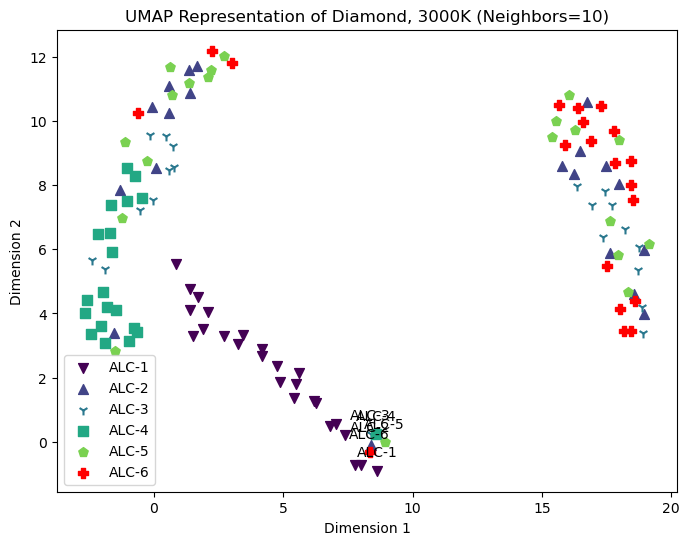

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_labels[cleaned_labels == last_label] = 6
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you inte

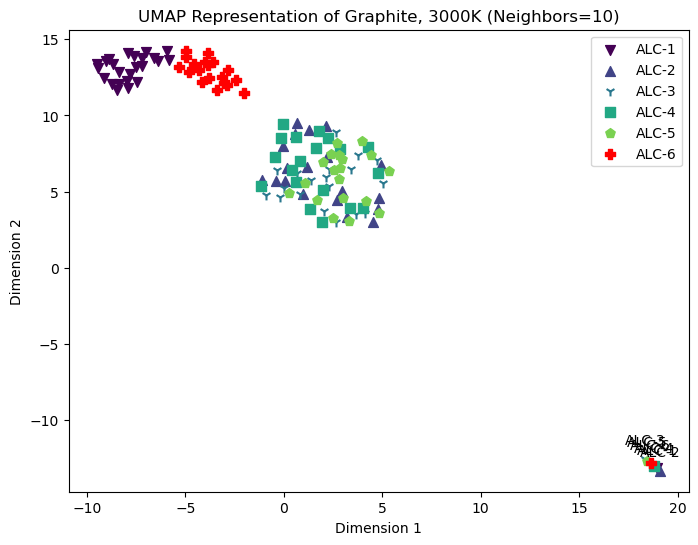

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_labels[cleaned_labels == last_label] = 6
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you inte

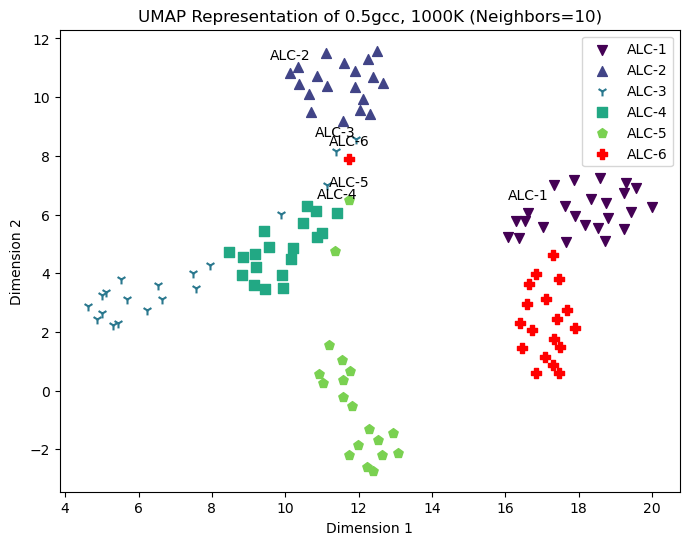

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_labels[cleaned_labels == last_label] = 6
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you inte

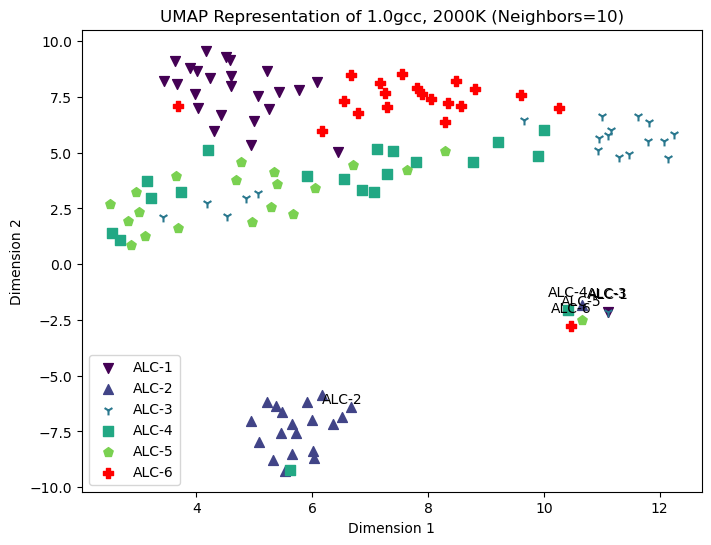

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_labels[cleaned_labels == last_label] = 6
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you inte

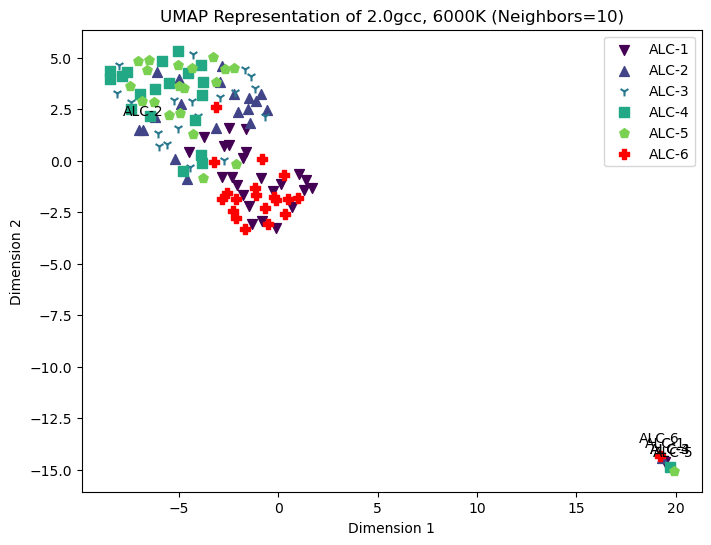

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_labels[cleaned_labels == last_label] = 6
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you inte

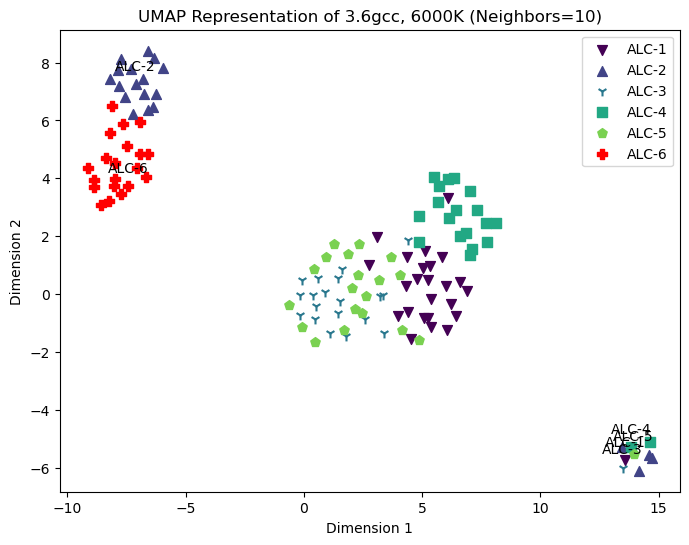

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_labels[cleaned_labels == last_label] = 6
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_68129/308214149.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you inte

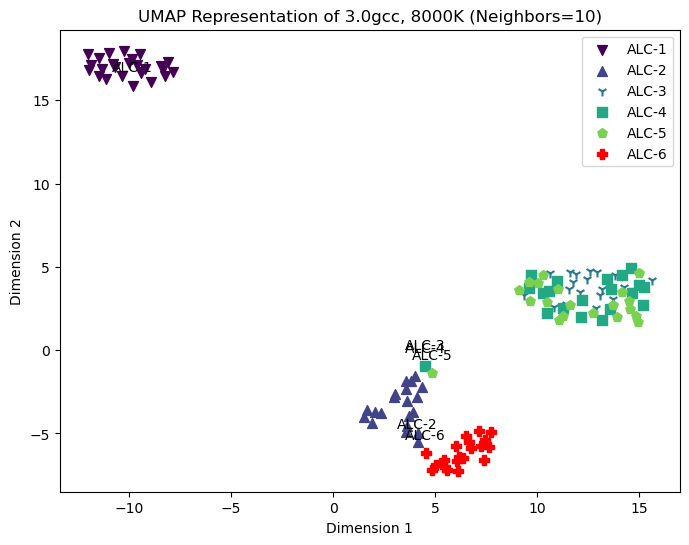

In [8]:
# Function to plot UMAP representation
def plot_umap(embedding, cleaned_labels, title, dft_only):
    plt.figure(figsize=(8, 6))
    label_dict = {}  # Dictionary to store whether each label has been plotted

    shape_map = [".","v","^","1","s","p","P","*","x","d","+","H"]    
    last_label = cleaned_labels.iloc[-1]
    cleaned_labels[cleaned_labels == last_label] = 6
    
    for i in range(len(embedding)):
        x, y = embedding[i]  # Coordinates of the point
        label = int(cleaned_labels.iloc[i])
        # Normalize label data to range [0, 1]
        normalized_label = (label - 1) / (6 - 1)

        # Determine color
        if dft_only == True and label != 1:
            continue
        if label == 6:
            color = "red"
        else:
            if dft_only:
                normalized_label = (i-1)/(26-1)
            color = plt.cm.viridis(normalized_label)

        # Plot points with unique labels and add them to the legend
        if label not in label_dict:
            label_dict[label] = True
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50, label=f"ALC-{label}")
            plt.annotate(f"ALC-{label}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        else:
            plt.scatter(x, y, c=color, cmap='viridis', marker=shape_map[label], s=50)

    # Add colorbar to show the mapping from index to color
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title(title)
    plt.show()


# Function to process and plot data
def process_and_plot_data(data, labels, title, n_neighbors, dft_only=False):
    # Concatenate data and labels
    stacked_df = pd.concat(data, ignore_index=True)
    stacked_labels = pd.concat(labels, ignore_index=True)
    stacked_df["Labels"] = stacked_labels

    # Drop NaN values and extract cleaned labels
    removedna_df = stacked_df.dropna()
    cleaned_labels = removedna_df["Labels"]

    # Extract removed labels
    removed_labels = removedna_df.drop(columns=["Labels"])

    # Compute UMAP embedding
    umap_model = umap.UMAP(random_state=1, n_components=2, n_neighbors=n_neighbors, min_dist=0.7)
    embedding = umap_model.fit_transform(removed_labels)

    # Plot the embedded data with colors and shapes based on labels
    plot_umap(embedding, cleaned_labels, f'{title} (Neighbors={n_neighbors})', dft_only)

sp_list = [0, 1, 2, 3, 4, 5, 6]
title_list = ['UMAP Representation of Diamond, 3000K',
              'UMAP Representation of Graphite, 3000K',
              'UMAP Representation of 0.5gcc, 1000K',
              'UMAP Representation of 1.0gcc, 2000K',
              'UMAP Representation of 2.0gcc, 6000K',
              'UMAP Representation of 3.6gcc, 6000K',
              'UMAP Representation of 3.0gcc, 8000K']
phase_list = ["diamond", "graphite", "liquid", "liquid", "liquid", "liquid", "liquid"]
T_list = [3000, 3000, 1000, 2000, 6000, 6000, 8000]
rho_list = [3.67, 2.67, 0.5, 1, 2, 3.6, 3]

for index, sp_cnt in enumerate(sp_list):
    # Filter rows where the 'phase' column is equal to 'diamond'
    rows = df[(df['phase'] == phase_list[index]) & (df['T'] == T_list[index]) & (df['rho'] == rho_list[index]) & (df['Good/bad'] != 'Bad')]

    # Define your datasets and labels
    data = [
        alc_master_list[i][sp_cnt*int(rows.iloc[i]["Total frames"]):sp_cnt*int(rows.iloc[i]["Total frames"])+int(rows.iloc[i]["Total frames"])] for i in range(6)
    ]
    #print(rows)

    labels = [
        pd.DataFrame(np.full(int(row["Total frames"]), int(row["Eff ALC"]))) for _, row in rows.iterrows()
    ]
    #print(labels)

    process_and_plot_data(data, labels, title_list[index], 10, dft_only=False)
